I'm submitting the task with a week delay, using 8-15 delay days

Video - https://drive.google.com/file/d/1z2eFzAYxQ8023_uIlsMpTr_qrUauTIGl/view?usp=share_link


In [72]:
import torch
import math
from matplotlib import pyplot as plt


In [73]:
def my_sampler(size,dist,requires_grad=False):
  dist = torch.tensor(dist)
  # Validate dist input - sum of all probs is 1 and all of them are posiive 
  assert (dist.sum() == 1.0 and dist.all()), f"dist is invalid array, sum != 1 or not positive, dist: {dist}"

  # Get cumulative sum of dist, in otder to compare to sigma of all the values without calcualting it for every value 
  dist = dist.cumsum(dim=0)

  U = torch.rand(size)

  # Default values are I=0, will remain for U < p_0
  result = torch.zeros(size, requires_grad = False, dtype=torch.double)

  # Second option, if U >= sigma(dist from 0 to n-1) I=n
  result = torch.where(U >= torch.sum(dist[:-1]), float(dist.numel() - 1), result)

  for i in range(len(dist)-1):

    # Find midle value which fills the terms 
    middle_value = torch.logical_and(dist[i - 1] <= U, U < dist[i])
    result = torch.where(middle_value, float(i), result)


  result.requires_grad = requires_grad
  return result, U

    

In [74]:
def validate_sample(result, U, dist):
  print("Validating sample")
  print("U", U)
  print("result", result) 
  dist = torch.tensor(dist)
  dist = dist.cumsum(dim=0)

  for r,u in zip(result, U):
    r_value = int(r.item())
    u_value = u.item()
    print(r_value,r, u_value, u)
    
    if r_value == 0:
      assert u < dist[0], f"Wrong 0, r: {r}, u: {u}, dist[0]: {dist[0]}"
    elif r_value == (dist.numel() - 1):
      assert u >= torch.sum(dist[:-1]), f"Wrong 0, r: {r}, u: {u}, dist[0]: {dist[0]}"
    else:
      assert torch.logical_and(dist[r_value - 1] <= u, u < dist[r_value]), f"Wrong value, r: {r}, u: {u}"

In [75]:
# sum(dist) > 1
result, U = my_sampler(10,[0.1,0.2, 0.6])

AssertionError: ignored

In [77]:
# 0 value in dist
result, U = my_sampler(10,[0.0,0.2, 0.6])

AssertionError: ignored

Validating sample
U tensor([0.4410, 0.0018, 0.5693, 0.0060, 0.7483, 0.7586, 0.7616, 0.1565, 0.9480,
        0.9601])
result tensor([2., 0., 2., 0., 2., 2., 2., 1., 2., 2.], dtype=torch.float64)
2 tensor(2., dtype=torch.float64) 0.44095003604888916 tensor(0.4410)
0 tensor(0., dtype=torch.float64) 0.001841723918914795 tensor(0.0018)
2 tensor(2., dtype=torch.float64) 0.5692919492721558 tensor(0.5693)
0 tensor(0., dtype=torch.float64) 0.005965173244476318 tensor(0.0060)
2 tensor(2., dtype=torch.float64) 0.7483227849006653 tensor(0.7483)
2 tensor(2., dtype=torch.float64) 0.7586255669593811 tensor(0.7586)
2 tensor(2., dtype=torch.float64) 0.7616266012191772 tensor(0.7616)
1 tensor(1., dtype=torch.float64) 0.15653550624847412 tensor(0.1565)
2 tensor(2., dtype=torch.float64) 0.9480065107345581 tensor(0.9480)
2 tensor(2., dtype=torch.float64) 0.9601357579231262 tensor(0.9601)


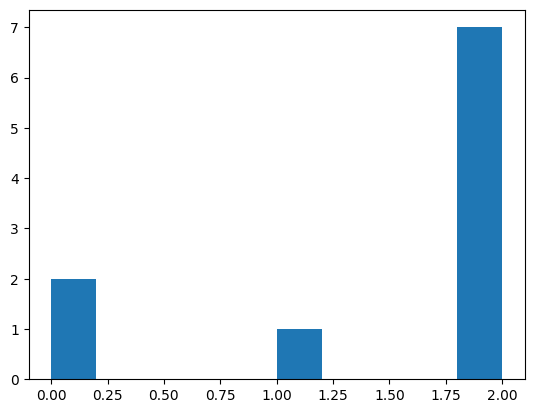

In [86]:
result, U = my_sampler(10,[0.1,0.2, 0.7])
validate_sample(result, U, [0.1,0.2, 0.7])

result = result.detach().numpy()
plt.hist(result)
plt.show()

In [87]:
class MyScalar:
    def __init__(self, value, gradient = torch.tensor(0), parent = None):
      self.value = value
      self.gradient = gradient
      self.parent = parent

    def __repr__(self):
        return f"value: {self.value}, gradient: {self.gradient}, parent: {self.parent}"

    def __str__(self):
        return f"value: {self.value}, gradient: {self.gradient}, parent: {self.parent}"

def add(current, other):
  # Derivative is 1
  return MyScalar(current.value + other, torch.tensor(1), current)
  
def mul(current, other):
    # Derivative is other
    return MyScalar(current.value * other, torch.tensor(other), current)


def pow(current, other):
    # Derivative is other * (value ^ (other-1))
    return MyScalar(current.value ** other, other *  (current.value ** (other -1)), current)

def exp(current):
    # Derivative is e ^ value
    return MyScalar(torch.exp(torch.tensor(current.value)), torch.exp(torch.tensor(current.value)), current)

def ln(current):
    # Derivative is 1/value
    return MyScalar(torch.log(torch.tensor(current.value)), 1/current.value, current)    

def sin(current):
    # Derivative is cos(value)
    return MyScalar(torch.sin(torch.tensor(current.value)), torch.cos(torch.tensor(current.value)), current)

def cos(current):
    # Derivative is sin(value)
    return MyScalar(torch.cos(torch.tensor(current.value)), -torch.sin(torch.tensor(current.value)), current)


In [88]:
def get_gradient_recursive(MyScalar_Input, results, partial_grad):
  results[MyScalar_Input] = partial_grad

  if MyScalar_Input.parent is None:
    return partial_grad
  
  return get_gradient_recursive(MyScalar_Input.parent, results, partial_grad * MyScalar_Input.gradient)

def get_gradient(MyScalar_Input):
   results = dict()
   partial_grad = get_gradient_recursive(MyScalar_Input, results, torch.tensor(1))

   return results


In [89]:
# My gradient system
a=MyScalar(2)
b = add(a, 1)
c = mul(b, 2)
d = cos(c)
e = sin(d)
f = ln(e)
g=pow(f,2)
h=exp(g)
i=get_gradient(h)

# Pytorch gradient system
a_torch_grad = torch.tensor([2.], requires_grad=True)
b_torch_grad  = torch.add(a_torch_grad, 1)
c_torch_grad  = torch.mul(b_torch_grad, 2)
d_torch_grad  = torch.cos(c_torch_grad)
e_torch_grad  = torch.sin(d_torch_grad)
f_torch_grad  = torch.log(e_torch_grad)
g_torch_grad  = torch.pow(f_torch_grad, 2)
h_torch_grad  = torch.exp(g_torch_grad)

h_torch_grad.backward()

print("My gradient system: ", i.values())
print("Torch gradient system: ", a_torch_grad.grad)



My gradient system:  dict_values([tensor(1), tensor(1.0405), tensor(-0.4148), tensor(-0.5063), tensor(-0.2903), tensor(-0.0811), tensor(-0.1622), tensor(-0.1622)])
Torch gradient system:  tensor([-0.1622])


<ipython-input-87-cbb726029edd>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return MyScalar(torch.sin(torch.tensor(current.value)), torch.cos(torch.tensor(current.value)), current)
<ipython-input-87-cbb726029edd>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return MyScalar(torch.log(torch.tensor(current.value)), 1/current.value, current)
<ipython-input-87-cbb726029edd>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return MyScalar(torch.exp(torch.tensor(current.value)), torch.exp(torch.tensor(current.value)), current)
